In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import numpy.random as rn

In [3]:
from sklearn import tree

In [4]:
import xgboost as xgb

## The Gini Coefficient

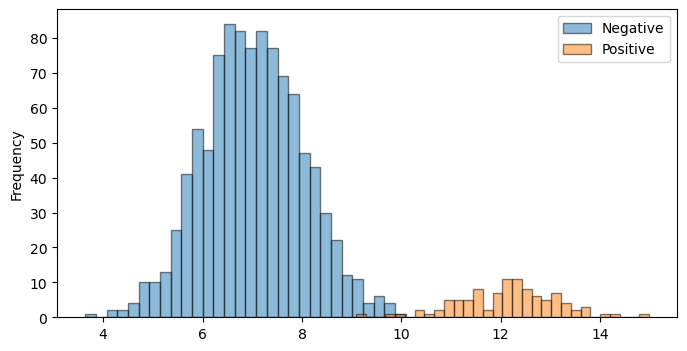

In [5]:
pos_center = 12
pos_count = 100
neg_center = 7
neg_count = 1000
rs = rn.RandomState(rn.MT19937(rn.SeedSequence(42)))
gini = pd.DataFrame({'value':
    np.append((pos_center) + rs.randn(pos_count),
              (neg_center) + rs.randn(neg_count)),
                     'label':
    ['pos']* pos_count + ['neg'] * neg_count})

fig, ax = plt.subplots(figsize=(8, 4))
_ = (gini
 .groupby('label')
 [['value']]
     .plot.hist(bins=30, alpha=.5, ax=ax, edgecolor='black')
)
ax.legend(['Negative', 'Positive'])

In [6]:
def calc_gini(df, val_col, label_col, pos_val, split_point,
              debug=False):
    """
    This function calculates the Gini impurity of a dataset. Gini impurity 
    is a measure of the probability of a random sample being classified 
    incorrectly when a feature is used to split the data. The lower the 
    impurity, the better the split.

    Parameters:
    df (pd.DataFrame): The dataframe containing the data
    val_col (str): The column name of the feature used to split the data
    label_col (str): The column name of the target variable
    pos_val (str or int): The value of the target variable that represents 
        the positive class
    split_point (float): The threshold used to split the data.
    debug (bool): optional, when set to True, prints the calculated Gini
        impurities and the final weighted average

    Returns:
    float: The weighted average of Gini impurity for the positive and 
        negative subsets.
    """    
    ge_split = df[val_col] >= split_point
    eq_pos = df[label_col] == pos_val
    tp = df[ge_split & eq_pos].shape[0]
    fp = df[ge_split & ~eq_pos].shape[0]
    tn = df[~ge_split & ~eq_pos].shape[0]
    fn = df[~ge_split & eq_pos].shape[0]
    pos_size = tp+fp
    neg_size = tn+fn
    total_size = len(df)
    if pos_size == 0:
        gini_pos = 0
    else:
        gini_pos = 1 - (tp/pos_size)**2 - (fp/pos_size)**2
    if neg_size == 0:
        gini_neg = 0
    else:
        gini_neg = 1 - (tn/neg_size)**2 - (fn/neg_size)**2
    weighted_avg = gini_pos * (pos_size/total_size) + \
                   gini_neg * (neg_size/total_size)
    if debug:
        print(f'{gini_pos=:.3} {gini_neg=:.3} {weighted_avg=:.3}')
    return weighted_avg

In [7]:
calc_gini(gini, val_col='value', label_col='label', pos_val='pos',
          split_point=9.24, debug=True)

gini_pos=0.217 gini_neg=0.00202 weighted_avg=0.0241


0.024117224644432264

In [8]:
values = np.arange(5, 15, .1)
ginis = []
for v in values:
    ginis.append(calc_gini(gini, val_col='value', label_col='label',
                           pos_val='pos', split_point=v))
pd.Series(ginis, index=values).loc[9.5:10.5]

9.6     0.013703
9.7     0.010470
9.8     0.007193
9.9     0.005429
10.0    0.007238
10.1    0.005438
10.2    0.005438
10.3    0.007244
10.4    0.009046
10.5    0.009046
dtype: float64

Text(0.5, 0, 'Split Point')

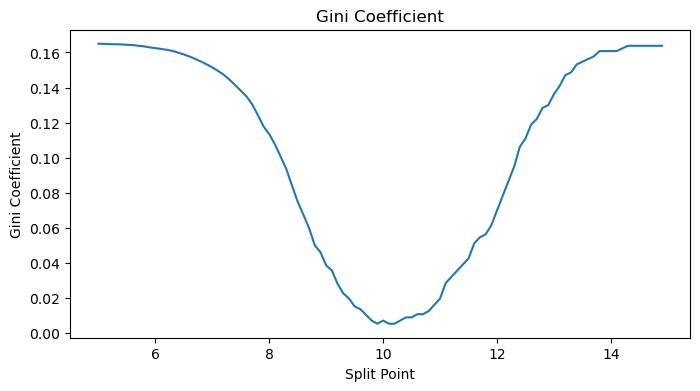

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))    
ax.plot(values, ginis)
ax.set_title('Gini Coefficient')
ax.set_ylabel('Gini Coefficient')
ax.set_xlabel('Split Point')

In [10]:
print(pd.DataFrame({'gini':ginis, 'split':values})
      .query('gini <= gini.min()')
     )

        gini  split
49  0.005429    9.9


## Coefficients in Trees

In [11]:
stump = tree.DecisionTreeClassifier(max_depth=1)
stump.fit(gini[['value']], gini.label)

DecisionTreeClassifier(max_depth=1)

[Text(0.5, 0.75, 'value <= 9.708\ngini = 0.165\nsamples = 1100\nvalue = [1000, 100]\nclass = neg'),
 Text(0.25, 0.25, 'gini = 0.002\nsamples = 999\nvalue = [998, 1]\nclass = neg'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.039\nsamples = 101\nvalue = [2, 99]\nclass = pos'),
 Text(0.625, 0.5, '  False')]

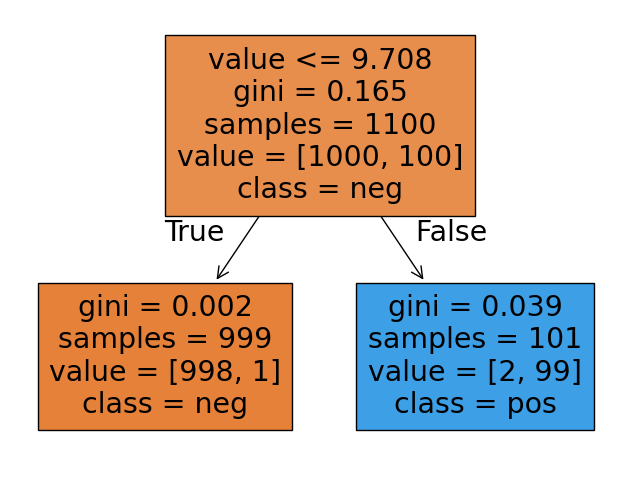

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
tree.plot_tree(stump, feature_names=['value'],
               filled=True, 
               class_names=stump.classes_,
               ax=ax)

In [13]:
gini_pos = 0.039
gini_neg = 0.002
pos_size = 101
neg_size = 999

total_size = pos_size + neg_size
weighted_avg = gini_pos * (pos_size/total_size) + \
    gini_neg * (neg_size/total_size)
print(weighted_avg)

0.005397272727272727


## XGBoost stump

<Axes: >

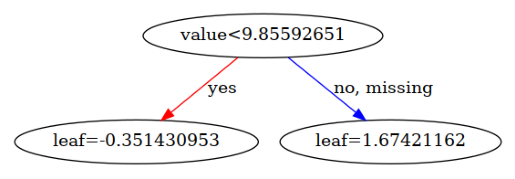

In [14]:
xg_stump = xgb.XGBClassifier(n_estimators=1, max_depth=1)                 
xg_stump.fit(gini[['value']], (gini.label== 'pos'))

xgb.plot_tree(xg_stump, num_trees=0)